In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 4)

from util import util
import os
import numpy as np
from tensorflow.keras import callbacks
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from tensorflow import keras
from bayes_opt import BayesianOptimization

import warnings
warnings.simplefilter("ignore")

# Load data
data_folder = os.path.join('..', 'data')
data = util.load_data(data_folder)

# Identify input columns
dt_in = list(data.columns[3:-1]) # Exclude metadata

# Focus on a subset of the data
data_by_src = util.split_by_field(data, field='src')
dt = data_by_src['train_FD004']

# Split training and test machines
tr_ratio = 0.75
np.random.seed(42)
machines = dt.machine.unique()
np.random.shuffle(machines)

sep = int(tr_ratio * len(machines))
tr_mcn = machines[:sep]
ts_mcn = machines[sep:]

tr, ts = util.partition_by_machine(dt, tr_mcn)

# Standardization and normalization
trmean = tr[dt_in].mean()
trstd = tr[dt_in].std().replace(to_replace=0, value=1) # handle static fields
ts_s = ts.copy()
ts_s[dt_in] = (ts_s[dt_in] - trmean) / trstd
tr_s = tr.copy()
tr_s[dt_in] = (tr_s[dt_in] - trmean) / trstd

trmaxrul = tr['rul'].max()
ts_s['rul'] = ts['rul'] / trmaxrul 
tr_s['rul'] = tr['rul'] / trmaxrul 

# Define a cost model
failtimes = dt.groupby('machine')['cycle'].max()
safe_interval = failtimes.min()
maintenance_cost = failtimes.max()
cmodel = util.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)

# Bayesian (Surrogate-Based) Optimization

## Bayesian Optimization

**We will use an approach known as _Surrogate-Based Bayesian Optimization_**

* It is designed to optimize _blackbox functions_
* I.e. functions with an unknown structure, that can only be evaluated

**Formally, they address problems in the form:**

$$
\min_{x \in B} f(x)
$$

* Where $B$ is a box, i.e. a specification of bounds for each component of $x$
* In our case, the decision variable $x$ would be $\theta$
* ...And the function to be optimized would be the cost

**The functions are typically assumed to be _expensive to evaluate_**

## Why a Surrogate

**Since evaluating $f$ is expensive, it should be done _infrequently_**

The main trick to achieve this is using a _surrogate model_

* After each evaluation we train _a Machine Learning model_
* ...Then we perform optimization _on the ML model_
* ...Since it can be evaluate much more quickly

The process is usually start by sampling a few random points

**This is where the name stems from**

* Since we use the ML model instead of the function, we call it a _surrogate_
* Moreover, we optimize over _prior_ information (i.e. the current model)
* ...And we refine the model based on the evaluation (_posterior_)
* Hence we call it _Bayesian Optimization_

## A Running Example

**Let's assume we want to minimize the following function over $[0, 1]$**

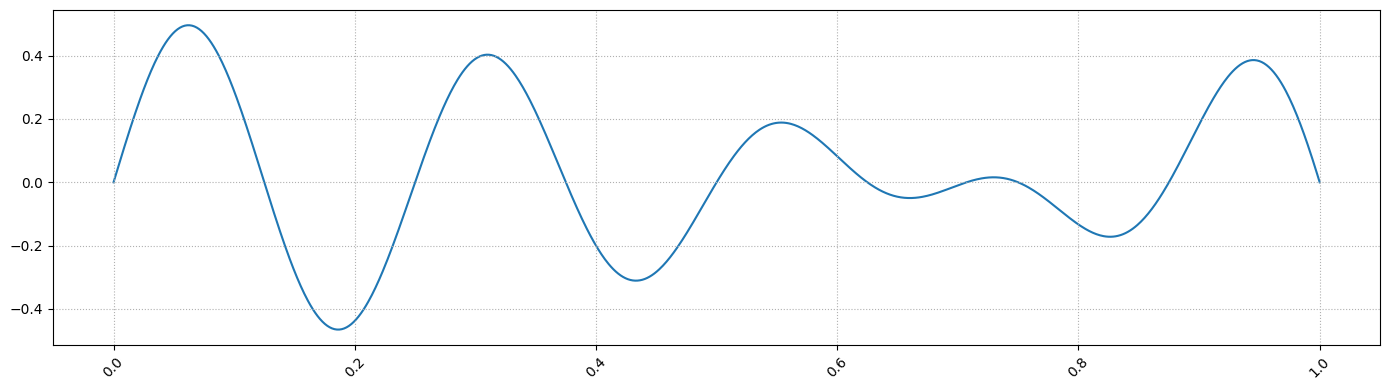

In [2]:
bbf = lambda x: (0.5 - x**2) * np.sin(2 * 4 * np.pi * x)
xrange = np.linspace(0, 1, 1000)
target = pd.Series(index=xrange, data=bbf(xrange))
util.plot_series(target, figsize=figsize)

* There multiple local minima, and the global minimum is at $\simeq 0.19$

## A Running Example

**Let's start by sampling a few points at random**

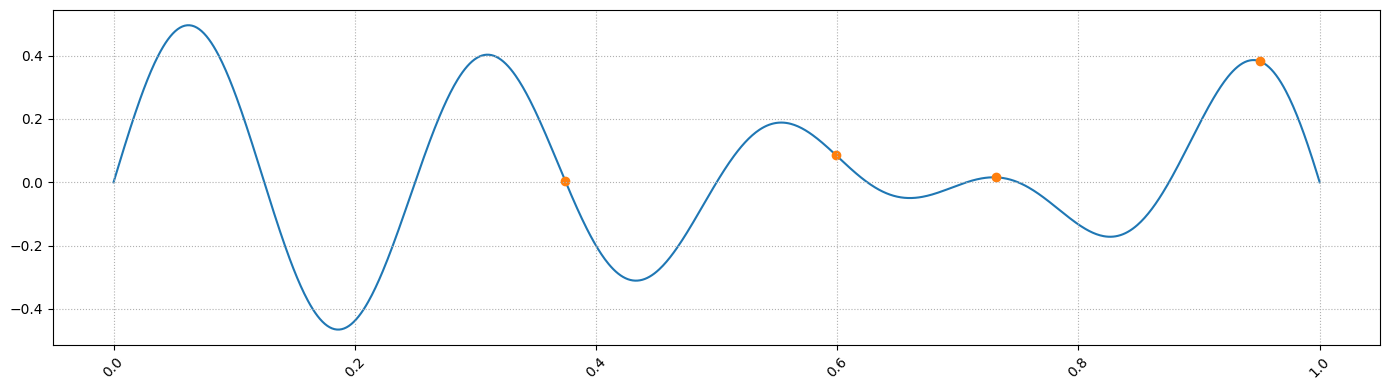

In [3]:
np.random.seed(42)
xtr = np.sort(np.random.random(4))
ytr = bbf(xtr)
util.plot_series(target, figsize=figsize)
plt.scatter(xtr, ytr, color='tab:orange');

* Using _only the orange points_ we need to train a model
* ...That gives us a good idea for a new point to evaluate

<div class=big>Which properties should our surrogate model have?</div>

## Properties of a Good Surrogate

**Our surrogate model should**

Approximate very accurately all evaluted points

* Assuming the function is deterministic
* ...The available evaluations are exact values

Reflect our confidence level on unexplored regions

* If we have few samples in a certain region
* ...We might want to search there just to see what the function looks like

> **Can you think of a ML model with these properties?**

## Gaussian Process Surrogates

**Gaussian Processes check all the boxes!**

* They can interpolate very well known measurements
* They provide a confidence level that decays with distance from observations

**Let's try to train a simple GP for our example**

In [4]:
kernel = RBF(0.01, (1e-3, 1e3)) + WhiteKernel(1e-3, (1e-6, 1e-2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True)
gpr.fit(xtr.reshape(-1, 1), ytr);
gpr.kernel_

RBF(length_scale=0.0792) + WhiteKernel(noise_level=0.000126)

* We use an _RBF kernel_ to capture the distance-based correlation
* We also use a _white noise kernel_ to avoid numerical instability
* ...But we keep it at a low value since the target function is deterministic

## Gaussian Process Surrogate

**Let's inspect our Gaussian Process Surrogate**

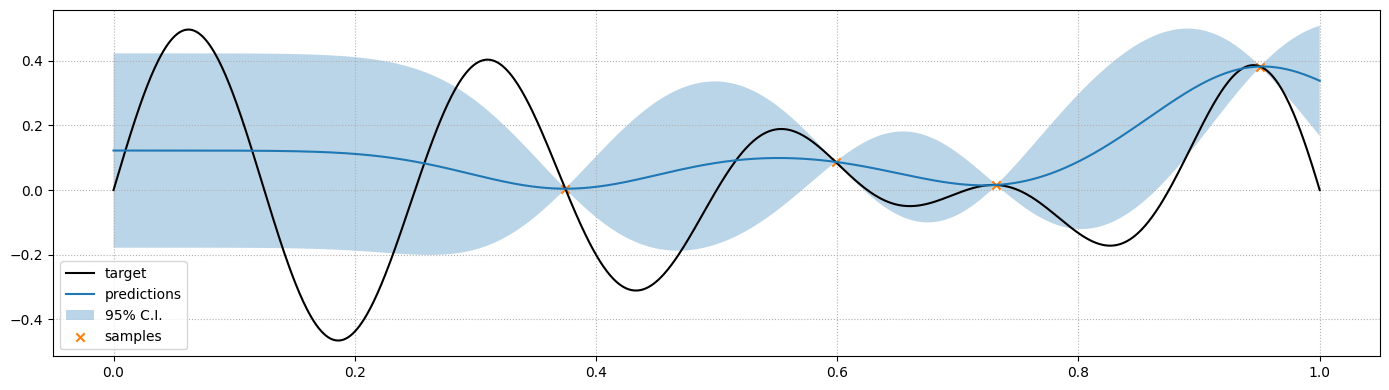

In [5]:
pmean, pstd = gpr.predict(xrange.reshape(-1, 1), return_std=True)
util.plot_gp(target=target, figsize=figsize, pred=pd.Series(index=xrange, data=pmean),
             std=pd.Series(index=xrange, data=pstd), samples=pd.Series(index=xtr, data=ytr))

* All known points are interpolated (almost) exactly
* ...And the confidence intervals behave in an intuitive fashion

## What to Optimize?

**Now we need to search over the surrogate model**

This is the same as choosing _which function to optimize_

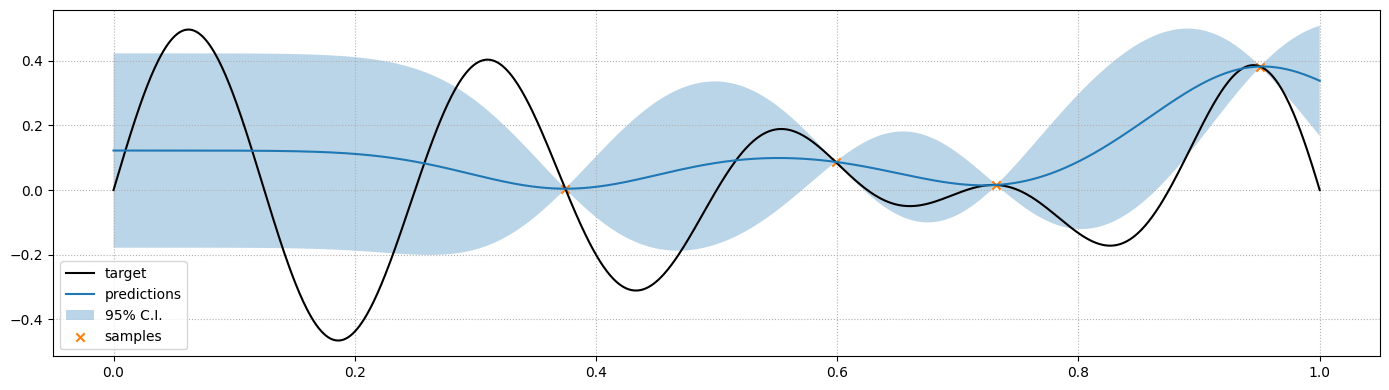

In [6]:
pmean, pstd = gpr.predict(xrange.reshape(-1, 1), return_std=True)
util.plot_gp(target=target, figsize=figsize, pred=pd.Series(index=xrange, data=pmean),
             std=pd.Series(index=xrange, data=pstd), samples=pd.Series(index=xtr, data=ytr))

> **Which area does it make sense to explore, and why?**

## Acquisition Function

**We need to account for both the _predictions_ and their _confidence_**

* Area with _low predictions_ are promising
* ...But so are also areas with _high confidence_

**This issue is solved in SBO by optimizig an _acquisition function_**

...Which should balance _exploration_ and _exploitation_.

* [Examples](https://optimization.cbe.cornell.edu/index.php?title=Bayesian_Optimization#Acquisition_Function) include the Probability of improvement, the Expected Improvement
* ...And the Lower/Upper confidence bound

**We will use the Lower Confidence Bound, which is given by:**

$$
\mathit{LCB}(x) = \mu(x) - Z_\alpha \sigma(x)
$$

* Where $\mu(x)$ is the predicted mean, $\sigma(x)$ is the predicted standard deviation
* ...And $Z_\alpha$ is multiplier for a $\alpha\%$ Normal confidence inteval

## Lower Confidence Bound

**Let's see an examle in our case with $Z_\alpha = 2.5$**

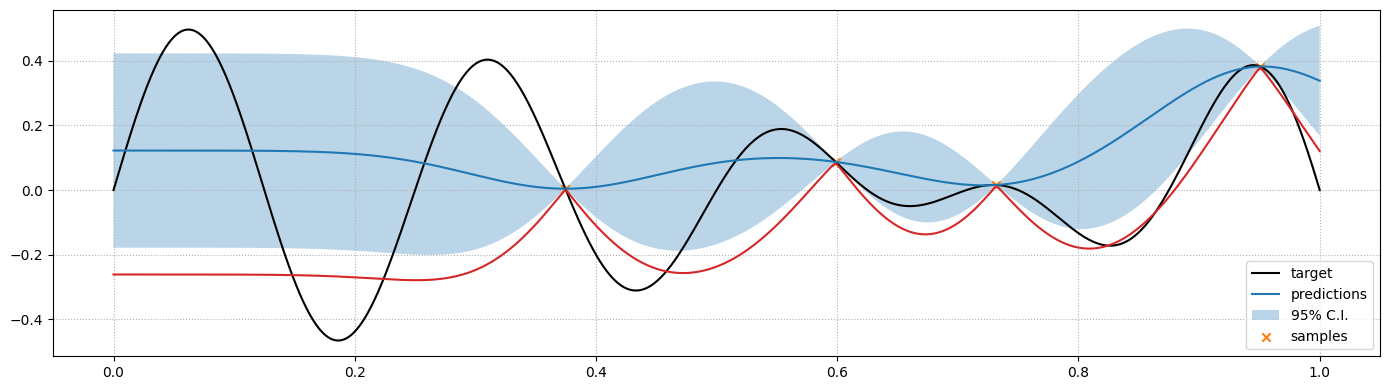

In [7]:
lcb = pmean - 2.5 * pstd
util.plot_gp(target=target, figsize=figsize, pred=pd.Series(index=xrange, data=pmean), std=pd.Series(index=xrange, data=pstd), samples=pd.Series(index=xtr, data=ytr))
plt.plot(xrange, lcb, color='tab:red');

* We can then optimize via any method applicable to our surrogate
* E.g. [Nelder-Mead](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method), Mathmatical Programming, or even simple grid search

## Lower Confidence Bound

**Let's see which point we would choose in our case**

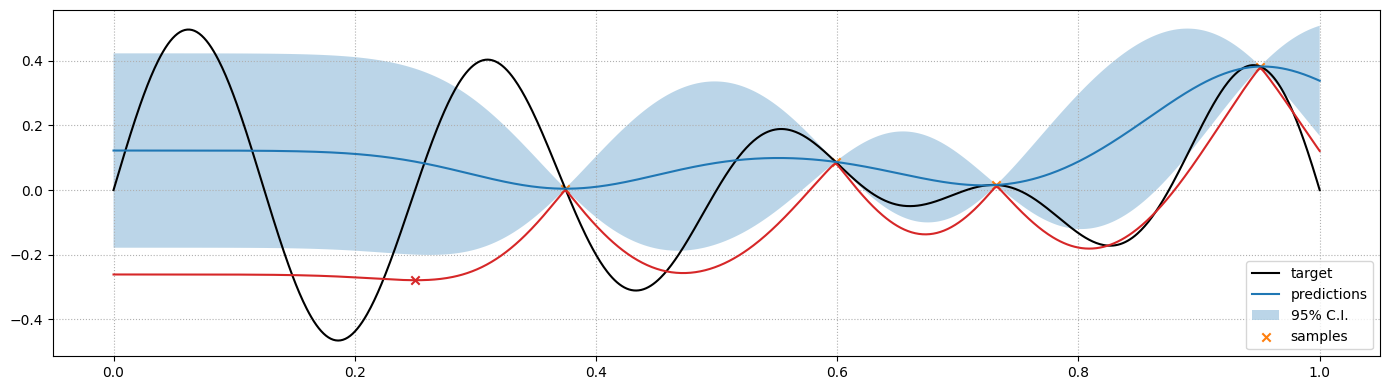

In [8]:
best_idx = np.argmin(lcb)
util.plot_gp(target=target, figsize=figsize, pred=pd.Series(index=xrange, data=pmean), std=pd.Series(index=xrange, data=pstd), samples=pd.Series(index=xtr, data=ytr))
plt.plot(xrange, lcb, color='tab:red');
plt.scatter(xrange[best_idx], lcb[best_idx], marker='x', color='tab:red');

* The $x$ value with the best acquisition function is highlighted with a red "x"

## Updating the Surrogate

**Now wen update our surrogate model**

First, we evaluate $f$ for the new point and grow our training set:

In [9]:
xtr2 = np.hstack((xtr, [xrange[best_idx]]))
ytr2 = np.hstack((ytr, [bbf(xrange[best_idx])]))

Then we can retrain our Gaussian Process:

In [10]:
gpr2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True)
gpr2.fit(xtr2.reshape(-1, 1), ytr2);
gpr2.kernel_

RBF(length_scale=0.0999) + WhiteKernel(noise_level=2.46e-06)

* Then we should optimize the acquisition function again
* ...But we will limit ourselves to showing the updated predictions

## Updating the Surrogate

**Here are the estimates for the udpate surrorate**

...Together with the acquisition function and the next iterate

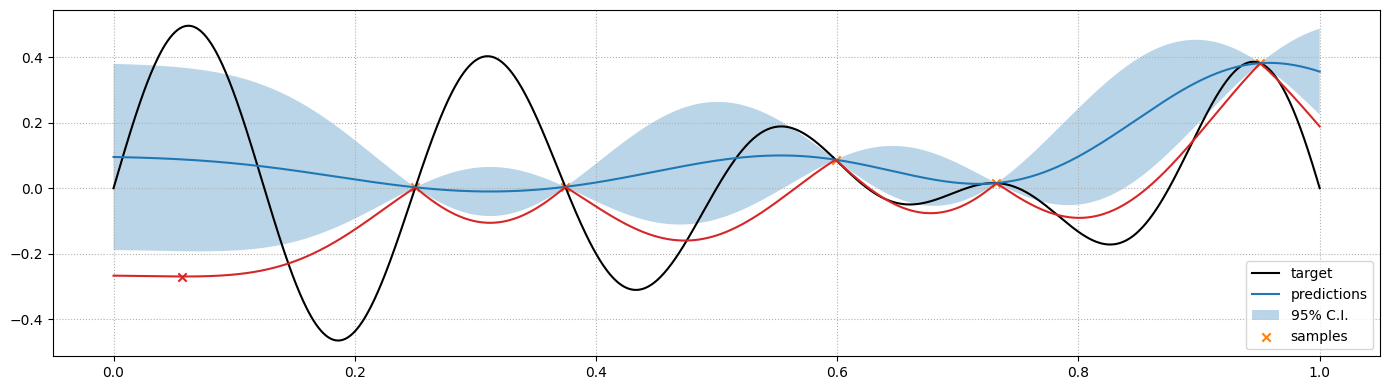

In [11]:
pmean2, pstd2 = gpr2.predict(xrange.reshape(-1, 1), return_std=True)
lcb2 = pmean2 - 2.5 * pstd2
best_idx2 = np.argmin(lcb2)
util.plot_gp(target=target, figsize=figsize, pred=pd.Series(index=xrange, data=pmean2), std=pd.Series(index=xrange, data=pstd2), samples=pd.Series(index=xtr2, data=ytr2))
plt.plot(xrange, lcb2, color='tab:red');
plt.scatter(xrange[best_idx2], lcb2[best_idx2], marker='x', color='tab:red');

## Surrogate-Based Bayesian Optimization

**Let's review the general method**

* Given a collection $\{x_i, y_i\}_i$ of evaluated points
* ...We train a surrogate-model $\hat{f}$ for $f$

**Then we proceed as follows:**

* We optimize an acquisition function $a_\hat{f}(x)$ to find a value $x^\prime$
* We evaluate $y^\prime = f(x^\prime)$
* If $y^\prime$ is better than the current optimum $f(x^*)$:
  - Then we replace $x^*$ with $x^\prime$
* We expand our collection of measurements to include $(x^\prime, y^\prime)$
* We retrain $\hat{f}$
* We repeat until a termination condition is reached

## A Few Considerations

**Different Bayesian optimization algorithms:**

* Make use of different surrogate models
* Rely on different criteria for choosing $x^\prime$
* Strike different trade-offs in terms of number of (expensive) evaluations of $f$
* ...And the quality of the obtained solutions

**For more information, see (e.g.) [this tutorial](https://machinelearningmastery.com/what-is-bayesian-optimization/)**

**In practice, you don't have to code from scratch**

...Since multiple libraries are available, like:

* The [`scikit-optimize` package](https://scikit-optimize.github.io/stable/index.html) (crude, reasonably fast, unfortunately unmaintained)
* The [`bayesian-optimization` python module](https://github.com/fmfn/BayesianOptimization) (more stable, but also slower)
* The [RBFOpt solver](https://github.com/coin-or/rbfopt) (stable, fast, more complex in terms of requirements)

# SBO for Threshold Calibration

## Back to Our Motivating Problem

**We will use SBO to tackle our policy definition problem**

$$\begin{align}
\mathop{\text{argmin}}_{\varepsilon} & \sum_{k \in K} \mathit{cost}(f(x_k\, \theta^*), 1/2) \\
\text{ s.t.: } & \theta^* = \mathop{\text{argmin}}_\theta L(f(x_k, \lambda), \mathbb{1}_{y_k \geq \varepsilon})
\end{align}$$

Here's our plan:

* We need to optimize over $\varepsilon$
* Our goal is minimizing the cost
* Computing the cost requires to re-define the classes
* ...And therefore to repeat training

**Our implementation will be based on [bayesian-optimization](https://github.com/fmfn/BayesianOptimization)**

## The Black Box Function

**As a first step, we need to define our black box function**

We will use a function class (in the `util` module) with this structure:

```python
class ClassifierCost:
    def __init__(self, machines, X, y, cost_model, init_epochs=20, inc_epochs=3):
        ...

    def __call__(self, params):
        ...
```

* In the constructor, we provide parameters that are fixed during optimization
* In the `__call__` method, we retrain the model and evaluate the cost
* The `__call__` method is executed when we try to invoke an object of this class
* ...Meaning that we can treat an object of this class as a normal function

## The Black Box Function

**It is worth having a deeper look at the `__call__` method**

```python
def __call__(self, params):
    theta = params[0] # There is only one parameter to optimize
    lbl = (self.y >= theta) # Redefine classes
    # Determine the number of epochs and retrain
    epochs = self.init_epochs if not self.is_init else self.inc_epochs
    self.is_init = True
    train_nn_model(self.nn, self.X, lbl, loss='binary_crossentropy', epochs=epochs,
            verbose=0, patience=10, batch_size=32, validation_split=0.2)
    ...
```

* At each execution we redefine the classes
* We use warm starting to make the process faster
* Each training attempt after the first uses only a few epochs

## The Black Box Function

**It is worth having a deeper look at the `__call__` method**

```python
def __call__(self, params):
    ...
    self.stored_weights[theta] = self.nn.get_weights() # Store weights
    # Evaluate cost
    pred = np.round(self.nn.predict(self.X, verbose=0).ravel())
    cost, fails, slack = self.cost_model.cost(self.machines, pred, 0.5, return_margin=True)
    return cost
```

* We store the weights in a dictionary for later retrieval
* We need this to rebuild the optimal network once optimization is over
* Finally, we evaluate the cost
* The actual code in `util` also prints some information

## The Black Box Function

**We can build an object in the usual way**

In [13]:
ccf = util.ClassifierCost(machines=tr['machine'], X=tr_s[dt_in], y=tr['rul'], cost_model=cmodel)

...But since it is a function, we can _invoke_ it:

In [14]:
ccf(20, verbose=True)

eps: 20.00, avg. cost: -88.96, avg. fails: 0.00, avg. slack: 27.48


16547

* The function returns the negated cost
* ...Since `bayesian-optimization` is designed for maximization

## Running the Solver

**Now we can define our box constraints and run the optimization process**

In [15]:
pbounds = {'eps': (1, 20)} # Box constraints
optimizer = BayesianOptimization(f=ccf, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=3, n_iter=10)

|   iter    |  target   |    eps    |
-------------------------------------
| 1         | 1.871e+04 | 8.116     |
| 2         | 1.657e+04 | 19.06     |
| 3         | 1.73e+04  | 14.91     |
| 4         | -5.761e+0 | 1.192     |
| 5         | 1.815e+04 | 11.33     |
| 6         | 1.632e+04 | 17.07     |
| 7         | 1.812e+04 | 9.54      |
| 8         | 1.764e+04 | 13.09     |
| 9         | 1.641e+04 | 20.0      |
| 10        | 1.827e+04 | 7.082     |
| 11        | 1.814e+04 | 7.599     |
| 12        | 1.909e+04 | 5.732     |
| 13        | 1.586e+04 | 6.213     |


* The implementation is very close to what we have showed
* The results will be a bit noisy, since training is stochastic

## Retrieve the Results

**We can access the best $\varepsilon$ value from a result data structure**

In [16]:
print(optimizer.max)
best_eps = optimizer.max['params']['eps']

{'target': 19091.0, 'params': {'eps': 5.731594133424523}}


We will use it to retrive the weights of the best network:

In [17]:
nn = keras.models.clone_model(ccf.nn)
nn.set_weights(ccf.stored_weights[best_eps])

* This is possible since we stored all the tested weights in our class

## Evaluate the Classifier

**Finally, we can evaluate our classifier**

In [18]:
tr_pred = np.round(nn.predict(tr_s[dt_in], verbose=0).ravel())
ts_pred = np.round(nn.predict(ts_s[dt_in], verbose=0).ravel())

tr_c, tr_f, tr_sl = cmodel.cost(tr['machine'].values, tr_pred, 0.5, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, 0.5, return_margin=True)
print(f'Avg. cost: {tr_c/len(tr_mcn)} (training), {ts_c//len(ts_mcn)} (test)')
print(f'Avg. fails: {tr_f/len(tr_mcn)} (training), {ts_f/len(ts_mcn)} (test)')
print(f'Avg. slack: {tr_sl/len(tr_mcn):.2f} (training), {ts_sl/len(ts_mcn):.2f} (test)')

Avg. cost: -102.63978494623656 (training), -113 (test)
Avg. fails: 0.0 (training), 0.0 (test)
Avg. slack: 13.42 (training), 11.06 (test)


* The performance is now better than the regression approach!

## AutoML

**Many ML models have hyper parameters!**

...And tuning them may sometimes improve the performance

* The problem is that tuning multiple parameters may be complicated
* ...And every training attempts is expensive

**This makes hyper-parameter tuning a perfect application for SBO**

...And other similar approaches. A few libraries you might have heard of:

* [Hyperopt](https://github.com/hyperopt/hyperopt)
* [Optuna](https://optuna.org/)

**In recent years the concept has been generalized to AutoML**

...Where we can start chanking the architecture and model type, too!

* It's a big topic (and big techs have some available SW solutions)
* A good starting reference is [this web site](https://www.automl.org/)